# 13 · The Universality of Chaos — Scale Sweeps

**Observational record associated with the book**  
*Discovering Chaos in Prime Numbers — Computational Investigations through the Euler Mirror*  
© Alvaro Costa, 2025

This notebook is part of a canonical sequence of computational records.  
It introduces **no new hypotheses, conjectures, or interpretative models**.

Its sole purpose is to **record** the behaviour of arithmetic structures under an explicit,  
deterministic, and reproducible observation regime.

The complete conceptual interpretation is provided in the book.  
This notebook documents only the corresponding experiment.

**Licence:** Creative Commons BY–NC–ND 4.0  
Reading, execution, and citation are permitted.  
Modification, adapted redistribution, or independent commercial use are not permitted.


---

## 1. A Local Law or a Universal One?

In the previous chapters, we identified a striking result: when the prime numbers are observed through the lens of the **logarithmic scale**, the spectrum of the  
operator constructed from $\Delta_\pi(x)$ exhibits the statistical signature of the **GOE**, the hallmark of quantum chaos.

Up to this point, however, this observation has been made by fixing the analysis within a specific neighbourhood of the number line, for instance around $X_0 = 10^8$.

This leads to an inevitable question: **is this a local phenomenon, or a universal law?**

Is the “music” we hear at $10^8$ the same music that would emerge at $10^5$ or $10^3$?  
Or are we merely observing a contingent effect, dependent on the particular location chosen along the number line?

Random Matrix Theory provides a clear prediction: in genuinely chaotic systems, spectral statistics are **universal**, meaning that they are independent of the microscopic  
details of the system. If the connection between primes and the GOE is structural — rather than accidental — it must persist under shifts of scale.

This notebook is devoted to explicitly testing that hypothesis of universality.

---

## 2. The Experiment: A Sweep Across Orders of Magnitude

To investigate the robustness of the phenomenon, we perform a **scale sweep**. We keep the construction of the operator and the logarithmic observation lens fixed, while  
varying only the initial point $X_0$ across several orders of magnitude.

Concretely, we repeat the spectral analysis for values of $X_0$ ranging from $10^3$ up to $10^8$.

At each scale, we extract one of the most stable and informative signatures of the GOE: the **mean ratio of adjacent level spacings**, denoted by $\langle r \rangle$.

This statistic has two fundamental advantages:

* it is independent of global unfolding procedures;
* it allows a clear discrimination between Poisson and GOE regimes.

**Experimental hypothesis:**  
if the GOE regime is universal, the value of $\langle r \rangle$ should remain approximately constant and close to the theoretical GOE value  
($\langle r \rangle \approx 0.536$), regardless of the scale $X_0$.


--- Precomputing all required prime numbers ---
-> 28,715,862 primes generated in 2.02 seconds.

--- Analysing scale at X₀ = 1000 ---

--- Analysing scale at X₀ = 10000 ---

--- Analysing scale at X₀ = 100000 ---

--- Analysing scale at X₀ = 1e+06 ---

--- Analysing scale at X₀ = 1e+07 ---

--- Analysing scale at X₀ = 1e+08 ---


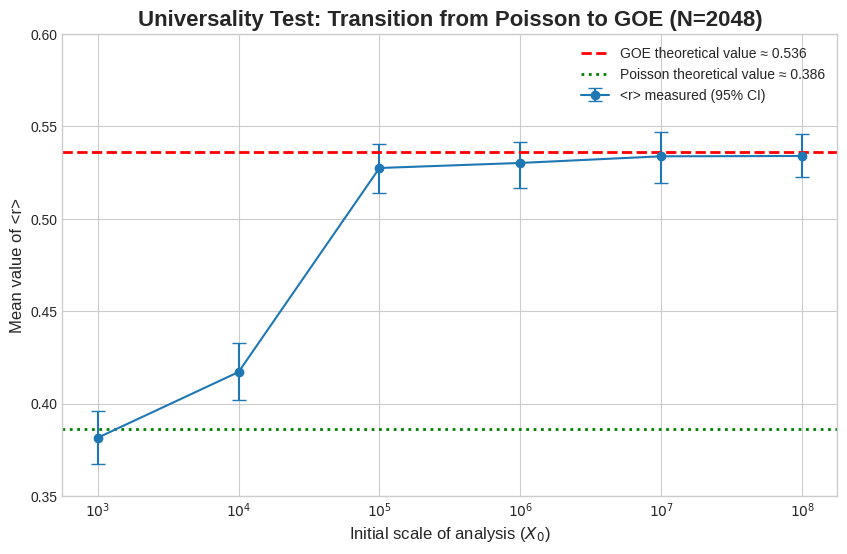

In [1]:
# Requirements: pandas, matplotlib, numpy, ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import time

# --- Data and Matrix Generation Functions (from the previous chapter) ---
def generate_pi_data(n: int) -> np.ndarray:
    """Generates an array containing all prime numbers up to n using an optimised sieve."""
    if n < 2:
        return np.array([], dtype=np.int64)

    size = (n - 1) // 2
    sieve = np.ones(size, dtype=bool)
    limit = int(np.sqrt(n)) // 2

    for i in range(limit):
        if sieve[i]:
            p = 2 * i + 3
            start = (p * p - 3) // 2
            sieve[start::p] = False

    indices = np.where(sieve)[0]
    odd_primes = 2 * indices + 3

    return np.concatenate((np.array([2], dtype=np.int64), odd_primes))


def get_delta_pi_for_points(x_points, primes):
    """Computes Δπ(x) for an array of points x using a precomputed list of primes."""
    x_int = np.floor(x_points).astype(int)
    pi_x = np.searchsorted(primes, x_int, side='right')
    pi_x_div_2 = np.searchsorted(primes, x_int // 2, side='right')
    return pi_x - 2 * pi_x_div_2


def generate_cos_matrix(fx_values, x_values):
    fx = fx_values.astype(np.float64)
    x = x_values.astype(np.float64)

    x[x <= 0] = 1e-12
    logx = np.log(x)

    C = np.cos(np.outer(fx, logx))
    M = C + C.T

    std_dev = M.std()
    if std_dev > 0:
        M -= M.mean()
        M /= std_dev

    return 0.5 * (M + M.T)


# --- <r> Analysis Function (from Chapter 8) ---
def r_mbb_bootstrap(s, B=200, block_size=16, seed=0):
    rng = np.random.default_rng(seed)
    n = len(s)

    if n < 2 * block_size:
        return np.nan, (np.nan, np.nan)

    num_blocks = int(np.ceil(n / block_size))
    r_bootstrapped = []

    for _ in range(B):
        start_indices = rng.integers(0, n - block_size + 1, size=num_blocks)
        s_resampled = np.concatenate(
            [s[i:i + block_size] for i in start_indices]
        )[:n]

        if len(s_resampled) < 2:
            continue

        r_vals = np.minimum(
            s_resampled[:-1], s_resampled[1:]
        ) / np.maximum(
            s_resampled[:-1], s_resampled[1:]
        )

        r_bootstrapped.append(np.mean(r_vals))

    if not r_bootstrapped:
        return np.nan, (np.nan, np.nan)

    mean_r = np.mean(r_bootstrapped)
    ci_95 = np.percentile(r_bootstrapped, [2.5, 97.5])

    return mean_r, ci_95


# --- Main Scale Sweep Function (OPTIMISED) ---
def scale_sweep_lab(N=2048, span=3.4):
    # Increase span to 4.0 for stronger GOE signatures

    log_X0_values = [3, 4, 5, 6, 7, 8]
    x_labels = [f"$10^{i}$" for i in log_X0_values]

    results_r = []
    results_ci_lower = []
    results_ci_upper = []

    # --- OPTIMISATION: generate all required primes only once ---
    print("--- Precomputing all required prime numbers ---")

    final_X0 = int(10 ** log_X0_values[-1])
    max_x_global = int(np.ceil(final_X0 * np.exp(span / 2)))

    start_time = time.time()
    primes = generate_pi_data(max_x_global)
    end_time = time.time()

    print(f"-> {len(primes):,} primes generated in {end_time - start_time:.2f} seconds.")
    # ------------------------------------------------------------

    # --- Scale Sweep Loop (now much faster) ---
    for log_X0 in log_X0_values:
        X0 = int(10 ** log_X0)
        print(f"\n--- Analysing scale at X₀ = {X0:g} ---")

        # Logarithmic-scale analysis
        x_log = np.exp(
            np.linspace(
                np.log(X0) - span / 2,
                np.log(X0) + span / 2,
                N
            )
        )

        fx_log = get_delta_pi_for_points(x_log, primes)

        M_log = generate_cos_matrix(fx_log, x_log)
        lam_log, _ = np.linalg.eigh(M_log)

        # <r> statistic
        s = np.diff(np.sort(lam_log))
        s = s[s > 0]

        mean_r, (ci_low, ci_high) = r_mbb_bootstrap(s)

        results_r.append(mean_r)
        results_ci_lower.append(mean_r - ci_low)
        results_ci_upper.append(ci_high - mean_r)

    # --- Final Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    y_err = [results_ci_lower, results_ci_upper]
    ax.errorbar(
        log_X0_values,
        results_r,
        yerr=y_err,
        fmt='o-',
        capsize=5,
        label='<r> measured (95% CI)'
    )

    ax.axhline(0.5359, ls='--', color='red', lw=2, label='GOE theoretical value ≈ 0.536')
    ax.axhline(0.3863, ls=':', color='green', lw=2, label='Poisson theoretical value ≈ 0.386')

    ax.set_xticks(log_X0_values)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("Initial scale of analysis ($X_0$)", fontsize=12)
    ax.set_ylabel("Mean value of <r>", fontsize=12)
    ax.set_title(
        f"Universality Test: Transition from Poisson to GOE (N={N})",
        fontsize=16,
        weight='bold'
    )

    ax.legend()
    ax.set_ylim(0.35, 0.6)
    plt.show()


# --- Run the analysis ---
# Note: this cell may still take some time, but most of it is spent on the initial prime precomputation.
scale_sweep_lab()


---

## 3. The Transition to Universal Chaos

The journey that began with the number $1$ and the construction of an elementary operator reaches here its point of convergence.  
The **scale-sweep experiment** provides clear empirical evidence for one of the central conclusions of this study.

The plot produced in this notebook should not be read merely as a numerical outcome, but as a **dynamic map** of the different statistical phases  
of the prime number universe.

As the behaviour of the statistic $\langle r \rangle$ is tracked while the initial scale $X_0$ increases, three well-defined regimes emerge.

### The Low-Scale Regime: The Echo of Order

For small values of $X_0$ (such as $10^3$ and $10^4)$, the statistic (\langle r \rangle) remains close to the characteristic **Poisson** value.

At these scales, the distribution of primes is still strongly influenced by local arithmetical irregularities.  
The signal $\Delta_\pi(x)$ does not yet possess sufficient complexity to sustain long-range spectral correlations.

The system therefore remains in a decorrelated regime, close to its baseline state.

### The Transition Zone: The Awakening of Chaos

Around $X_0 \sim 10^5$, a clear qualitative change is observed.  
The value of $\langle r \rangle$ rises rapidly, settling between the typical Poisson and GOE values. This interval corresponds to a  
**transition region**, in which the structural complexity of the prime signal reaches a critical mass. Correlations begin to emerge, but do not yet  
fully dominate the spectrum.

This is a genuine intermediate regime, analogous to a phase transition.

### The Asymptotic Regime: GOE Universality

At scales of the order of $X_0 \sim 10^7$ and beyond, the behaviour stabilises.
The statistic $\langle r \rangle$ converges to the theoretical value predicted by the **GOE** and acquires a crucial property:

> **it becomes independent of scale.**

The result obtained at $10^7$ is essentially indistinguishable from that observed at $10^8$.  
We have entered the asymptotic regime, where the connection between Number Theory and Random Matrix Theory manifests itself as a **universal law**.

---

## 4. Final Synthesis

The trajectory revealed by this notebook resolves the initial puzzle posed by the duality observed in the preceding chapters.

The change in statistical behaviour was not a contradiction, but the portrait of a journey:

* from local order,
* through a transition region,
* to the emergence of a universal and structured chaos.

The music of the prime numbers is not a local accident.  
It is a deep constant of the mathematical universe —  
audible only when we learn to listen at the proper scale.
